In [1]:
import sys
sys.path.insert(0,'..')

from src.definitions import *
from src.plotting import *
from src.processing import *
from src.plotting import *
from src.stats import *
from src.figures import *
from tqdm.notebook import tqdm

#universal participants

daily_stressed_participants = get_participants("daily_stressed")

daily_shifts_participants = get_participants("daily_shifts")
    
shift_stress_participants = get_participants("shift_stress")
        
hrv_binary_participants = get_participants("hrv_binary")

#any_stress_participants = get_participants("any_stress")


universal_participants = [p for p in shift_stress_participants if (p in daily_stressed_participants and p in daily_shifts_participants and p in hrv_binary_participants)]
len(universal_participants)

stress_shifts_hrv_participants = [p for p in daily_stressed_participants if (p in daily_shifts_participants and p in hrv_binary_participants)]
len(stress_shifts_hrv_participants)

138

In [4]:
print(len(daily_stressed_participants))
print(len(daily_shifts_participants))
print(len(shift_stress_participants))
print(len(hrv_binary_participants))


194
277
68
236


In [2]:
def significance_testing(stress_definition, test_method = "KS", alternative="two_sided", show = False):
    with open("/h/snagaraj/SRfingers/results/PC/reference/"+stress_definition+"/results_df.pkl", 'rb') as f:
        df  = pickle.load(f)

    participants = []
    for p in df["participant_id"].unique():
        subset = df[df["participant_id"]==p]
        if len(subset[subset["label"]=="stress"].difference.unique())>1:
            participants.append(p)
            
    participants_p_val = []
    stress_definitions_p_val = []
    measures_p_val = []
    direction_p_val = []
    p_vals = []
    
    measures = ["difference", "int_union", "between_oura",
           "between_survey", "between_modality", "between_phys", "between_sleep", "between_mental", 
            "between_phys_sleep", "between_phys_mental", "between_sleep_mental"]
    
    for p in participants:
        subset = df[df["participant_id"]==p]
        for measure in measures:
            cat1 = subset[subset['label']=="stress"][measure].dropna().values
            cat2 = subset[subset['label']=="reference"][measure].dropna().values
            
            if test_method == "KS":
                p_val = ks_test(cat1, cat2, alternative)
            else:
                p_val = t_test(cat1, cat2)

            participants_p_val.append(p)
            stress_definitions_p_val.append(stress_definition)
            measures_p_val.append(measure)
            p_vals.append(p_val)

            mean = np.mean(cat1) #MEAN DIFFERENCE STRESS VS NON STRESS
            if mean>=0:
                direction_p_val.append("Loss")
            elif mean <0:
                direction_p_val.append("Gain")
                
    
    
    p_vals_df = {"participant_id": participants_p_val, "stress_definition": stress_definitions_p_val, 
            "measure": measures_p_val, "p_val": p_vals, "direction": direction_p_val}


    p_vals_df = pd.DataFrame.from_dict(p_vals_df)
    p_vals_df = p_vals_df.dropna()
    
    if show:
        print(stress_definition)
    concat = []
    for measure in measures:
        sub_df = p_vals_df[(p_vals_df["measure"]== measure)]

        sub_df = bonferroni_correct(sub_df, "p_val")
        sub_df = bh_correct(sub_df, "p_val")

        p_vals_df.loc[sub_df.index] = sub_df

        reject_fdr = sub_df[sub_df["reject_fdr"]==True]
        reject_bc = sub_df[sub_df["reject_bc"]==True]

        concat.append(sub_df)
        if show:
            print("    Measure: "+measure)
            print("        Post Benjamini-Hochberg:"+str(len(reject_fdr)) + " out of " + str(len(sub_df)) + " " + str(len(reject_fdr)/len(sub_df)*100))
            print("           Number with lower "+measure+" on Stress: " + str(len(reject_fdr[reject_fdr["direction"]=="Loss"])) + " " + str(len(reject_fdr[reject_fdr["direction"]=="Loss"])/len(reject_fdr)*100))
            #print("        Post Bonferroni:"+str(len(reject_bc)) + " out of " + str(len(sub_df)))
            #print("           Number with lower "+measure+" on Stress: " + str(len(reject_bc[reject_bc["direction"]=="Loss"])))


    return pd.concat(concat)

def definition_viability(df, measure):

        measure_df = df[df["measure"]==measure]
        
        participants_reject = []
        stress_definitions_reject = []
        number_reject = []
        direction_reject = []
        number_gained = []
        number_lost = []

        for p in measure_df.participant_id.unique():

            p_df =  measure_df[measure_df["participant_id"]==p]

            count = 0
            list_reject = []
            direction = []
            for stress_definition in p_df.stress_definition.unique():
                if p_df[p_df["stress_definition"]==stress_definition].reject_fdr.values[0] == 1:
                    list_reject.append(stress_definition)
                    count+=1
                    direction.append(p_df[p_df["stress_definition"]==stress_definition].direction.values[0])

            participants_reject.append(p)
            stress_definitions_reject.append(list_reject)
            number_reject.append(count)
            direction_reject.append(direction)
            gain_count = 0
            loss_count = 0

            for item in direction:
                if item == "Gain":

                    gain_count +=1
                elif item == "Loss":
                    loss_count += 1
            number_gained.append(gain_count)
            number_lost.append(loss_count)

        definition_viability = {"participant_id": participants_reject, "stress_definitions": stress_definitions_reject, "number_rejected": number_reject, "direction":direction_reject, "number_gained":number_gained, "number_lost":number_lost}
        definition_viability = pd.DataFrame.from_dict(definition_viability)
        print(measure)
        for i in range(0,5):
            try:
                print("    Number of Individuals with " +str(i)+" viable definitions",definition_viability.number_rejected.value_counts()[i])
            except KeyError:
                print("    Number of Individuals with " +str(i)+" viable definitions",0)
        
def significance_testing_pipeline(test_method = "KS", alternative = "two_sided", show=False):
    stress_definitions_list = ["daily_stressed", "daily_shifts", "shift_stress", "hrv_binary"]
    measures = ["difference", "int_union", "between_oura",
           "between_survey", "between_modality", "between_phys", "between_sleep", "between_mental", 
            "between_phys_sleep", "between_phys_mental", "between_sleep_mental"]
    all_dfs = []
    for stress_definition in stress_definitions_list:
        p_vals = significance_testing(stress_definition, test_method = test_method, alternative = alternative, show=show)
        all_dfs.append(p_vals)
    combined = pd.concat(all_dfs)
    for measure in measures:
        definition_viability(combined, measure)
        
    print("\nThose who were tested for all 4 definitions:")
    subset = combined[combined["participant_id"].isin(universal_participants)]
    for measure in measures:
        definition_viability(subset, measure)
        
    print("\nThose who were tested for Stress, Shifts, HRV:")
    subset = combined[combined["participant_id"].isin(stress_shifts_hrv_participants)]
    for measure in measures:
        definition_viability(subset, measure)

In [3]:
significance_testing_pipeline(test_method = "KS", show=True)

daily_stressed
    Measure: difference
        Post Benjamini-Hochberg:176 out of 194 90.72164948453609
           Number with lower difference on Stress: 88 50.0
    Measure: int_union
        Post Benjamini-Hochberg:159 out of 194 81.95876288659794
           Number with lower int_union on Stress: 159 100.0
    Measure: between_oura
        Post Benjamini-Hochberg:158 out of 194 81.44329896907216
           Number with lower between_oura on Stress: 64 40.50632911392405
    Measure: between_survey
        Post Benjamini-Hochberg:146 out of 194 75.25773195876289
           Number with lower between_survey on Stress: 81 55.47945205479452
    Measure: between_modality
        Post Benjamini-Hochberg:170 out of 194 87.62886597938144
           Number with lower between_modality on Stress: 92 54.11764705882353
    Measure: between_phys
        Post Benjamini-Hochberg:159 out of 194 81.95876288659794
           Number with lower between_phys on Stress: 83 52.20125786163522
    Measure: betw

../src/stats.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["p_value_bc"] = df[p_value_column] * len(df)
../src/stats.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reject_bc"] = 1*(df[p_value_column] < alpha / len(df))
../src/stats.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

daily_shifts
    Measure: difference
        Post Benjamini-Hochberg:269 out of 277 97.11191335740072
           Number with lower difference on Stress: 127 47.21189591078067
    Measure: int_union
        Post Benjamini-Hochberg:238 out of 277 85.92057761732852
           Number with lower int_union on Stress: 238 100.0
    Measure: between_oura
        Post Benjamini-Hochberg:242 out of 277 87.36462093862815
           Number with lower between_oura on Stress: 124 51.2396694214876
    Measure: between_survey
        Post Benjamini-Hochberg:254 out of 277 91.69675090252709
           Number with lower between_survey on Stress: 126 49.60629921259843
    Measure: between_modality
        Post Benjamini-Hochberg:241 out of 277 87.00361010830325
           Number with lower between_modality on Stress: 117 48.54771784232365
    Measure: between_phys
        Post Benjamini-Hochberg:248 out of 277 89.53068592057761
           Number with lower between_phys on Stress: 95 38.306451612903224
  

between_sleep_mental
    Number of Individuals with 0 viable definitions 10
    Number of Individuals with 1 viable definitions 67
    Number of Individuals with 2 viable definitions 119
    Number of Individuals with 3 viable definitions 87
    Number of Individuals with 4 viable definitions 29

Those who were tested for all 4 definitions:
difference
    Number of Individuals with 0 viable definitions 0
    Number of Individuals with 1 viable definitions 0
    Number of Individuals with 2 viable definitions 0
    Number of Individuals with 3 viable definitions 11
    Number of Individuals with 4 viable definitions 37
int_union
    Number of Individuals with 0 viable definitions 0
    Number of Individuals with 1 viable definitions 0
    Number of Individuals with 2 viable definitions 3
    Number of Individuals with 3 viable definitions 17
    Number of Individuals with 4 viable definitions 28
between_oura
    Number of Individuals with 0 viable definitions 0
    Number of Individuals

# Edge Frequency

In [4]:
edges_daily_stressed = return_edge_summary("daily_stressed")
print_frequent_edges(edges_daily_stressed, 0.5)

EDGES FREQUENTLY GAINED ON STRESS
('hr_average', 'log_hrv'):  29
('phq9_score', 'gad7_score'):  11
('hr_lowest', 'log_hrv'):  13
('promis_sri_score', 'fss_score'):  14
('efficiency', 'score'):  16
('temperature_delta', 'temperature_trend_deviation'):  35
('hr_average', 'hr_lowest'):  35
('total', 'score'):  18

EDGES FREQUENTLY LOST ON STRESS
('hr_average', 'log_hrv'):  26
('phq9_score', 'promis_sri_score'):  16
('pss4_score', 'phq9_score'):  13
('hr_lowest', 'log_hrv'):  32
('daily_control', 'sam8'):  31
('promis_sri_score', 'fss_score'):  14
('efficiency', 'score'):  22
('gad7_score', 'pss4_score'):  13
('shift_stress', 'daily_shifts'):  16
('temperature_delta', 'temperature_trend_deviation'):  21
('phq9_score', 'promis_sd5'):  11
('gad7_score', 'promis_sd5'):  10
('onset_latency', 'efficiency'):  34
('gad7_score', 'fss_score'):  12
('hr_average', 'hr_lowest'):  24
('shift_stress', 'sam8'):  13
('promis_sri_score', 'gad7_score'):  10
('breath_average', 'hr_average'):  12
('log_hrv', 

In [5]:
edges_daily_shifts = return_edge_summary("daily_shifts")
print_frequent_edges(edges_daily_shifts, 0.5)

EDGES FREQUENTLY GAINED ON STRESS
('pss4_score', 'phq9_score'):  14
('fss_score', 'phq9_score'):  11
('fss_score', 'pss4_score'):  13
('log_hrv', 'hr_lowest'):  31
('daily_stressed', 'daily_control'):  10
('pss4_score', 'EBTBP'):  10
('total', 'score'):  16
('hr_average', 'log_hrv'):  52
('gad7_score', 'pss4_score'):  10
('gad7_score', 'promis_sd5'):  10
('onset_latency', 'efficiency'):  34
('hr_average', 'hr_lowest'):  30
('fss_score', 'gad7_score'):  14
('breath_average', 'hr_average'):  16
('temperature_delta', 'temperature_trend_deviation'):  30
('shift_stress', 'gad7_score'):  15
('gad7_score', 'phq9_score'):  23
('fss_score', 'daily_control'):  10
('promis_sd5', 'fss_score'):  11
('shift_stress', 'promis_sd5'):  10
('phq9_score', 'promis_sri_score'):  14
('promis_sri_score', 'fss_score'):  22
('daily_stressed', 'sam8'):  32
('efficiency', 'score'):  31
('phq9_score', 'promis_es_score'):  12
('shift_stress', 'promis_sri_score'):  14
('breath_average', 'log_hrv'):  10
('fss_score',

In [6]:
edges_shift_stress = return_edge_summary("shift_stress")
print_frequent_edges(edges_shift_stress, 0.5)

EDGES FREQUENTLY GAINED ON STRESS
('hr_average', 'hr_lowest'):  15
('temperature_trend_deviation', 'temperature_delta'):  14
('hr_average', 'log_hrv'):  13

EDGES FREQUENTLY LOST ON STRESS
('hr_average', 'hr_lowest'):  14
('log_hrv', 'hr_lowest'):  12
('temperature_trend_deviation', 'temperature_delta'):  13
('hr_average', 'log_hrv'):  12
('daily_control', 'sam8'):  11


In [7]:
edges_hrv_binary = return_edge_summary("hrv_binary")
print_frequent_edges(edges_hrv_binary, 0.5)

EDGES FREQUENTLY GAINED ON STRESS
('daily_control', 'sam8'):  12
('hr_lowest', 'hr_average'):  49
('hr_average', 'log_hrv'):  22
('promis_sri_score', 'fss_score'):  27
('phq9_score', 'pss4_score'):  14
('temperature_delta', 'temperature_trend_deviation'):  28
('promis_sd5', 'fss_score'):  12
('daily_shifts', 'sam8'):  11
('daily_stressed', 'shift_stress'):  14
('efficiency', 'onset_latency'):  26
('promis_sd5', 'promis_sri_score'):  10
('sam8', 'shift_stress'):  11
('phq9_score', 'promis_sd5'):  15
('breath_average', 'hr_average'):  10
('hr_lowest', 'log_hrv'):  13
('phq9_score', 'gad7_score'):  12
('sam8', 'daily_stressed'):  15
('score', 'efficiency'):  24
('daily_stressed', 'daily_shifts'):  20
('promis_es_score', 'phq9_score'):  13
('promis_sri_score', 'phq9_score'):  11
('fss_score', 'gad7_score'):  13
('breath_average', 'temperature_delta'):  10
('gad7_score', 'pss4_score'):  17
('pss4_score', 'daily_control'):  18
('fss_score', 'phq9_score'):  10
('promis_sd5', 'pss4_score'):  1

# Edge Strength

In [9]:
# edges_list = []
# means_list = []
# p_vals_list = []
# participants_list_weight = []

# for p in daily_stressed_participants:
#     subset = daily_stressed_df[daily_stressed_df["participant_id"]==p]
#     edges, means, p_vals = return_weight_change(subset)
#     if len(edges)!=0:
#         for i in range(len(edges)):
#             edges_list.append(edges[i])
#             means_list.append(means[i])
#             p_vals_list.append(p_vals[i])
#             participants_list_weight.append(p)

# unique_edges = []
# for (a,b) in edges_list:
#     if (a,b) not in unique_edges and (b,a) not in unique_edges:
#         unique_edges.append((a,b))
        
# edges_same_order = []
# for (a,b) in edges_list:
#     if (a,b) in unique_edges:
#         edges_same_order.append((a,b))
#     elif (b,a) in unique_edges:
#         edges_same_order.append((b,a))

# weights_df = {"participant": participants_list_weight, "edge": edges_same_order, "mean_change": means_list, "p_val":p_vals_list}

# weights_df = pd.DataFrame.from_dict(weights_df)

In [10]:
# weights_df[weights_df["p_val"]<0.05].edge.value_counts()

In [11]:
# edges_list = []
# means_list = []
# p_vals_list = []
# participants_list_weight = []

# for p in participants_shifts:
#     subset = daily_shifts_df[daily_shifts_df["participant_id"]==p]
#     edges, means, p_vals = return_weight_change(subset)
#     if len(edges)!=0:
#         for i in range(len(edges)):
#             edges_list.append(edges[i])
#             means_list.append(means[i])
#             p_vals_list.append(p_vals[i])
#             participants_list_weight.append(p)

# unique_edges = []
# for (a,b) in edges_list:
#     if (a,b) not in unique_edges and (b,a) not in unique_edges:
#         unique_edges.append((a,b))
        
# edges_same_order = []
# for (a,b) in edges_list:
#     if (a,b) in unique_edges:
#         edges_same_order.append((a,b))
#     elif (b,a) in unique_edges:
#         edges_same_order.append((b,a))

# weights_df = {"participant": participants_list_weight, "edge": edges_same_order, "mean_change": means_list, "p_val":p_vals_list}

# weights_df = pd.DataFrame.from_dict(weights_df)

# Clustering

In [12]:
def clustering__pipeline():
    stress_definitions_list = ["daily_stressed", "daily_shifts", "shift_stress", "hrv_binary"]
    measures = ["difference", "int_union", "between_oura",
           "between_survey", "between_modality", "between_phys", "between_sleep", "between_mental", 
            "between_phys_sleep", "between_phys_mental", "between_sleep_mental"]
    all_dfs = []
    for stress_definition in stress_definitions_list:
        p_vals = plot_population_characteristics(significance_testing(stress_definition, test_method = "KS"), measures, stress_definition, plot=False)
        all_dfs.append(p_vals)
    combined = pd.concat(all_dfs)
    
    return combined

In [13]:
combined = clustering__pipeline()

difference
    effect of GAIN vs LOSS on hx_pain: 0.006857103744024185
int_union


/h/snagaraj/.conda/envs/stressrecov/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/h/snagaraj/.conda/envs/stressrecov/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


between_oura
between_survey
    effect of GAIN vs LOSS on mhx_mood: 0.03357175315458734
between_modality
between_phys
    effect of GAIN vs LOSS on hx_obesity: 0.0021716944687568684
between_sleep
    effect of GAIN vs LOSS on mhx_mood: 0.025976364696522435
between_mental
    effect of GAIN vs LOSS on hx_none: 0.030138799489750234
    effect of GAIN vs LOSS on hx_allergies: 0.029628802911933514
    effect of GAIN vs LOSS on hx_pain: 0.006524255476139403
    effect of GAIN vs LOSS on hx_any: 0.030138799489750245
    effect of GAIN vs LOSS on alcohol: 0.006427810682078243
between_phys_sleep
    effect of GAIN vs LOSS on hx_pain: 0.0018202417808082295
between_phys_mental
between_sleep_mental
difference
    effect of GAIN vs LOSS on ptsd_score: 0.02788345479516039
int_union
between_oura
between_survey
    effect of GAIN vs LOSS on dem_gender: 0.03760974917503532
    effect of GAIN vs LOSS on mhx_sleep: 0.03934892483531874
between_modality
    effect of GAIN vs LOSS on mhx_sleep: 0.026121088

In [14]:
combined

,stress_definition,measure,feature,p_val,direction,p_value_bc,reject_bc,reject_fdr,p_value_fdr
0,daily_stressed,difference,dem_age,0.949350,Gain Higher,34.176604,0,0,1.000000
1,daily_stressed,difference,weight,0.982142,Gain Higher,35.357119,0,0,1.000000
2,daily_stressed,difference,ace_score,0.870592,Loss Higher,31.341317,0,0,1.000000
3,daily_stressed,difference,ptsd_score,0.430479,Gain Higher,15.497258,0,0,1.000000
4,daily_stressed,difference,life_events_score,0.717342,Loss Higher,25.824302,0,0,1.000000
...,...,...,...,...,...,...,...,...,...
391,hrv_binary,between_sleep_mental,mhx_any,0.490782,Categorical,17.668155,0,0,0.995600
392,hrv_binary,between_sleep_mental,alcohol,0.703174,Categorical,25.314257,0,0,1.000000
393,hrv_binary,between_sleep_mental,binge,0.240364,Categorical,8.653093,0,0,0.859825
394,hrv_binary,between_sleep_mental,smoke,0.279343,Categorical,10.056356,0,0,0.859825


In [15]:
combined[combined["reject_fdr"]==1]

,stress_definition,measure,feature,p_val,direction,p_value_bc,reject_bc,reject_fdr,p_value_fdr
188,daily_stressed,between_phys,hx_obesity,0.002172,Categorical,0.078181,0,1,0.078181
303,daily_stressed,between_phys_sleep,hx_pain,0.001820,Categorical,0.065529,0,1,0.065529


In [16]:
def binarize_category(x):
    if x=="Gain":
        return 0
    elif x=="Loss":
        return 1
    else:
        return None

In [17]:
stress_definition = "daily_stressed"

p_vals_df = significance_testing(stress_definition, test_method = "KS")

df_once = load_once_complete()

df = p_vals_df[p_vals_df["measure"]=="difference"]
df = df[df["stress_definition"]==stress_definition]

merged_df = df.merge(df_once, on="participant_id", how = "left")

features_cont = ["dem_age", "weight", "ace_score", "ptsd_score", "life_events_score"]

features_cat = ["dem_gender", 'hx_none', 'hx_diabetes', 'hx_obesity', 'hx_heart',
        'hx_lung', 'hx_rheum', 'hx_kidney', 'hx_liver', 'hx_allergies',
        'hx_pain', 'hx_gi', 'hx_ent', 'hx_neuro', 'hx_other','hx_any',
        'mhx_none', 'mhx_mood', 'mhx_anxiety', 'mhx_psych', 'mhx_eating',
        'mhx_neurodev', 'mhx_sleep', 'mhx_suicide', 'mhx_learning',
        'mhx_other', 'mhx_any','alcohol', 'binge', 'smoke', 'exercise']

all_features = features_cont + features_cat

merged_df[all_features] = merged_df[all_features].fillna(merged_df[all_features].mean())

merged_df["direction"] = merged_df.apply (lambda row: binarize_category(row.direction), axis=1)



../src/stats.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["p_value_bc"] = df[p_value_column] * len(df)
../src/stats.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reject_bc"] = 1*(df[p_value_column] < alpha / len(df))
../src/stats.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [18]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


target = "direction"

# split data into X and y
X = merged_df[all_features].values
Y = merged_df[target].values
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 49.23%


In [19]:
stress_definition = "daily_stressed"
p_vals = significance_testing(stress_definition, test_method = "KS")

../src/stats.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["p_value_bc"] = df[p_value_column] * len(df)
../src/stats.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reject_bc"] = 1*(df[p_value_column] < alpha / len(df))
../src/stats.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [20]:
p_vals

,participant_id,stress_definition,measure,p_val,direction,p_value_bc,reject_bc,reject_fdr,p_value_fdr
0,U-11YJYE852QXSR8AUC2W1,daily_stressed,difference,7.822116e-02,Loss,1.517490e+01,0,1,8.622105e-02
11,U-12HDU523T7TSN18MQNTU,daily_stressed,difference,9.878183e-03,Loss,1.916368e+00,0,1,1.321633e-02
22,U-1AFJWXDX3WVA8ZEMEL35,daily_stressed,difference,1.111953e-01,Gain,2.157188e+01,0,0,1.211903e-01
33,U-1D2T72SSE7SWAZ6Y3WWR,daily_stressed,difference,4.117410e-04,Gain,7.987775e-02,0,1,6.886013e-04
44,U-1SD8QUMRYKE2G68Q3TLQ,daily_stressed,difference,1.548387e-01,Loss,3.003870e+01,0,0,1.641459e-01
...,...,...,...,...,...,...,...,...,...
2089,U-Z3HNZ1T74AS7NBBHS2MP,daily_stressed,between_sleep_mental,7.850159e-06,Loss,1.522931e-03,1,1,1.770850e-05
2100,U-ZFH3BJ26DDP4LRTQZG2M,daily_stressed,between_sleep_mental,3.211429e-05,Gain,6.230172e-03,1,1,6.489762e-05
2111,U-ZUY395L4QK8TQXMLTJNH,daily_stressed,between_sleep_mental,5.390208e-02,Gain,1.045700e+01,0,1,6.618357e-02
2122,U-9DB1ASK2TMEF1BB8W9JY,daily_stressed,between_sleep_mental,3.108080e-20,Gain,6.029674e-18,1,1,4.638211e-19


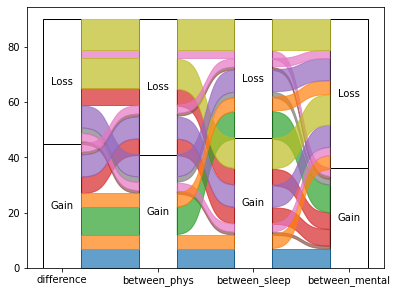

In [21]:
import pyalluvial.alluvial as alluvial

reports = []
sig_only = p_vals[p_vals["reject_fdr"]==1]
for a, sub_df in sig_only.groupby('participant_id'):
    rep = sub_df.pivot(None, 'measure', 'direction').ffill().bfill().drop_duplicates()
    rep.insert(0, 'participant_id', a)
    reports.append(rep)

result = pd.concat(reports).reset_index()
result

result['freq'] = 1
wide_df = result[["difference",'between_phys',"between_sleep", "between_mental", 'freq']].groupby(["difference",'between_phys',"between_sleep", "between_mental"], as_index=False).sum()
fig = alluvial.plot(df=wide_df, xaxis_names=["difference",'between_phys',"between_sleep", "between_mental"], y_name='freq', alluvium='freq')

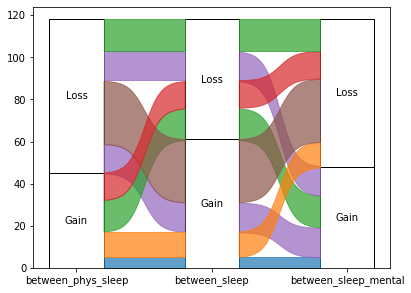

In [22]:
wide_df = result[["between_phys_sleep","between_sleep","between_sleep_mental", 'freq']].groupby(["between_phys_sleep","between_sleep","between_sleep_mental"], as_index=False).sum()
fig = alluvial.plot(df=wide_df, xaxis_names=["between_phys_sleep","between_sleep","between_sleep_mental"], y_name='freq', alluvium='freq')

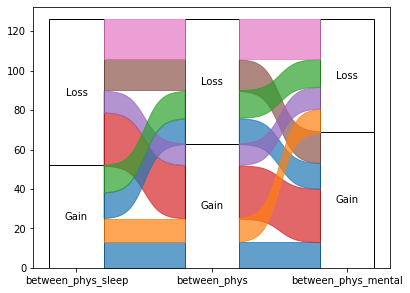

In [23]:
wide_df = result[["between_phys_sleep","between_phys","between_phys_mental", 'freq']].groupby(["between_phys_sleep","between_phys","between_phys_mental"], as_index=False).sum()
fig = alluvial.plot(df=wide_df, xaxis_names=["between_phys_sleep","between_phys","between_phys_mental"], y_name='freq', alluvium='freq')

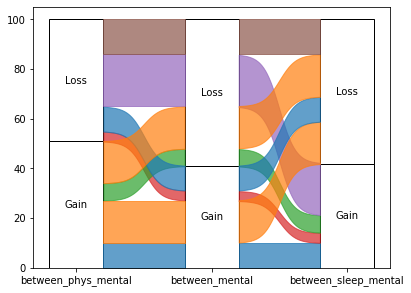

In [24]:
wide_df = result[["between_phys_mental","between_mental","between_sleep_mental", 'freq']].groupby(["between_phys_mental","between_mental","between_sleep_mental"], as_index=False).sum()
fig = alluvial.plot(df=wide_df, xaxis_names=["between_phys_mental","between_mental","between_sleep_mental"], y_name='freq', alluvium='freq')

In [25]:
wide_df

measure,between_phys_mental,between_mental,between_sleep_mental,freq
0,Gain,Gain,Gain,10
1,Gain,Gain,Loss,17
2,Gain,Loss,Gain,7
3,Gain,Loss,Loss,17
4,Loss,Gain,Gain,4
5,Loss,Gain,Loss,10
6,Loss,Loss,Gain,21
7,Loss,Loss,Loss,14


In [26]:
stress_definition = "daily_stressed"
p_vals_stress = significance_testing(stress_definition, test_method = "KS")
p_vals_stress = p_vals_stress[p_vals_stress["reject_fdr"]==1]
reports = []
for a, sub_df in p_vals_stress.groupby('participant_id'):
    rep = sub_df.pivot(None, 'measure', 'direction').ffill().bfill().drop_duplicates()
    rep.insert(0, 'participant_id', a)
    reports.append(rep)

p_vals_stress = pd.concat(reports).reset_index()


stress_definition = "hrv_binary"
p_vals_shifts = significance_testing(stress_definition, test_method = "KS")
p_vals_shifts = p_vals_shifts[p_vals_shifts["reject_fdr"]==1]
reports = []
for a, sub_df in p_vals_shifts.groupby('participant_id'):
    rep = sub_df.pivot(None, 'measure', 'direction').ffill().bfill().drop_duplicates()
    rep.insert(0, 'participant_id', a)
    reports.append(rep)

p_vals_shifts = pd.concat(reports).reset_index()

measures = ["between_oura", "between_survey","between_modality"]
directions = ["Gain", "Loss"]

for direction_a in directions:
    for direction_b in directions:
        for direction_c in directions:
            print(direction_a, direction_b, direction_c)
            
            participants_stress = p_vals_stress[(p_vals_stress[measures[0]]==direction_a) & (p_vals_stress[measures[1]]==direction_b) & (p_vals_stress[measures[2]]==direction_c)].participant_id.values
            participants_shifts = p_vals_shifts[(p_vals_shifts[measures[0]]==direction_a) & (p_vals_shifts[measures[1]]==direction_b) & (p_vals_shifts[measures[2]]==direction_c)].participant_id.values
            
            intersection = np.intersect1d(participants_stress, participants_shifts)
            minimum = min(len(participants_stress), len(participants_shifts))
            print(len(intersection)/minimum)
            

../src/stats.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["p_value_bc"] = df[p_value_column] * len(df)
../src/stats.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reject_bc"] = 1*(df[p_value_column] < alpha / len(df))
../src/stats.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Gain Gain Gain
0.09090909090909091
Gain Gain Loss
0.14285714285714285
Gain Loss Gain
0.0
Gain Loss Loss
0.17391304347826086
Loss Gain Gain
0.0
Loss Gain Loss
0.0
Loss Loss Gain
0.0
Loss Loss Loss
0.0


In [27]:
participants_stress

array(['U-ERTC7G8E7WRSPGSZLEXQ', 'U-GS4NJ3G9ZVUETDF1847D',
       'U-NZKTR5L6XXPT4BNQF3NQ', 'U-P96XSCJQA9C9RPU9H5J5',
       'U-PQ6VMYHWN3ZUFTJGBNB1', 'U-Q5TEKM5MERM28LNM2MSA',
       'U-W8W1LGU4TWZGMP2JMPX6'], dtype=object)

In [28]:
participants_shifts

array(['U-51YQ41XX3C54B86EM775', 'U-5LL4T2VTY2XQVDZPZN9D',
       'U-6WMY6MZLH43AGJ5SXGY5', 'U-9EHSLTTS3NTSRQNCWE4V',
       'U-ARYP79MANQZK7MBJFUT4', 'U-B9EERJ5XGKFNXMUP76P6',
       'U-HAQHE4KZYJR6S3F9UCJ4', 'U-J59TUBL3VMMXWGHDSSJM',
       'U-N421F8U39AU2DLFW14JK', 'U-P812DRUYRPHHSDUE9HN4',
       'U-PJ9V4R8JEQU91S4S1FBH', 'U-QKNWLB983T29KF5QSHJL',
       'U-UFQY97N16Q492SXRR17B', 'U-V74LC9CDNE3Z5FH1MWY5',
       'U-WUVPV3VUWGK4NWZNNMJ7', 'U-XH741P83KHQAPTEFWSQ4',
       'U-YT5AF8GSQA3WKACCU6H8', 'U-YY1J4CAB6VNDKUFHJ99E'], dtype=object)

In [29]:
np.intersect1d(participants_stress, participants_shifts)

array([], dtype=object)

# Edge Distributions

In [30]:
stress_definition = "daily_stressed"
with open("/h/snagaraj/SRfingers/results/PC/reference/"+stress_definition+"/results_df.pkl", 'rb') as f:
    df  = pickle.load(f)

In [31]:
df

,participant_id,label,difference,int_union,weight_diffs,edges_added,edges_removed,between_oura,between_survey,between_modality,between_phys,between_sleep,between_mental,between_phys_sleep,between_phys_mental,between_sleep_mental
0,U-11YJYE852QXSR8AUC2W1,stress,0.251314,0.555556,"{('gad7_score', 'promis_sd5'): -0.053674361976...","[(hr_average, log_hrv), (shift_stress, tempera...","[(daily_control, onset_latency), (daily_shifts...",1,-1,0,2,0,0,-2,0,0
1,U-11YJYE852QXSR8AUC2W1,stress,0.000000,0.166667,"{('temperature_delta', 'temperature_trend_devi...","[(promis_sd5, efficiency), (score, onset_laten...","[(efficiency, onset_latency), (daily_control, ...",-1,0,1,0,1,1,-2,0,0
2,U-11YJYE852QXSR8AUC2W1,stress,-0.154151,0.181818,"{('temperature_trend_deviation', 'temperature_...","[(promis_sd5, efficiency), (phq9_score, promis...","[(efficiency, onset_latency), (daily_control, ...",-2,-1,2,0,1,0,-2,0,0
3,U-11YJYE852QXSR8AUC2W1,stress,0.000000,0.625000,"{('temperature_delta', 'temperature_trend_devi...","[(hr_average, log_hrv)]","[(daily_control, onset_latency), (daily_shifts...",1,-1,-1,1,0,0,-2,0,0
4,U-11YJYE852QXSR8AUC2W1,stress,-0.154151,0.625000,"{('temperature_trend_deviation', 'temperature_...","[(daily_control, temperature_delta)]","[(daily_control, onset_latency), (daily_shifts...",0,-1,0,1,0,0,-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,U-LTQ1TJF6SSN7LR8NSRZD,reference,-inf,0.000000,{},[],"[(shift_stress, promis_sri_score), (gad7_score...",0,-3,0,0,0,0,-1,0,-2
39796,U-LTQ1TJF6SSN7LR8NSRZD,reference,-0.405465,0.000000,{},"[(gad7_score, promis_sri_score), (sam8, promis...","[(phq9_score, gad7_score), (pss4_score, gad7_s...",0,-1,0,0,0,-2,-1,-1,2
39797,U-LTQ1TJF6SSN7LR8NSRZD,reference,0.510826,0.400000,"{('gad7_score', 'promis_sri_score'): -0.020831...","[(daily_control, promis_sri_score), (pss4_scor...","[(daily_control, gad7_score)]",0,1,0,0,0,1,1,0,0
39798,U-LTQ1TJF6SSN7LR8NSRZD,reference,-0.693147,0.500000,"{('promis_sri_score', 'gad7_score'): -0.061048...",[],"[(phq9_score, promis_sd5), (fss_score, shift_s...",0,-2,0,0,0,0,-1,0,-1
